In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from tifffile import imread
import segmentation_models as sm
from random import randint
from tifffile import imread
import glob

Segmentation Models: using `tf.keras` framework.


# Import dataset

In [4]:

proj_uri = r'D:\NSC2024\QuPath_proj'

# images = np.memmap(proj_uri+'/memmap/images.mymemmap', dtype=np.uint8, mode='w+', shape=(1, 0))
# masks = np.memmap(proj_uri+'/memmap/masks.mymemmap', dtype=np.uint8, mode='w+', shape=(1, 0))
images = []
masks = []

export_uri = r'D:\NSC2024\QuPath_proj\export'
# export_uri = r'D:\OneDrive-CMU\Desktop_Dell\QuPath\export'

for base_uri in os.listdir(export_uri):
    for root, subdirs, files in os.walk(os.path.join(export_uri, base_uri, 'images')):
        for file in files:
            file_path = os.path.join(root, file)
            image = imread(file_path)

            images.append(image)
    
    for root, subdirs, files in os.walk(os.path.join(export_uri, base_uri, 'masks')):
        for file in files:
            file_path = os.path.join(root, file)
            mask = imread(file_path)

            masks.append(mask)

images = np.asarray(images)
masks = np.asarray(masks)

N = len(images)

print(images.shape)
print(masks.shape)

(80, 512, 512, 3)
(80, 3, 512, 512)


In [5]:
N = len(images)
SIZE = images.shape[-2]
n_classes = 4

print(N, SIZE, n_classes)

80 512 4


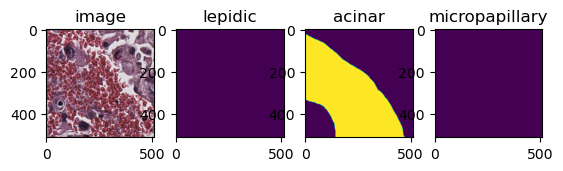

In [6]:
r = randint(0, len(images) - 1)

plt.subplot(1, 4, 1)
plt.title('image')
plt.imshow(images[r])

plt.subplot(1, 4, 2)
plt.title('lepidic')
plt.imshow(masks[r][0])

plt.subplot(1, 4, 3)
plt.title('acinar')
plt.imshow(masks[r][1])

plt.subplot(1, 4, 4)
plt.title('micropapillary')
plt.imshow(masks[r][2])

plt.show()

# print(masks[r][0])

In [7]:
print(np.unique(masks))
print(masks.shape)

[  0 255]
(80, 3, 512, 512)


# Process dataset

##### Convert labels' index

In [8]:
for idx in range(N):
    for c in range(3):
        masks[idx][c][masks[idx][c] == 255] = c + 1

[0 2]


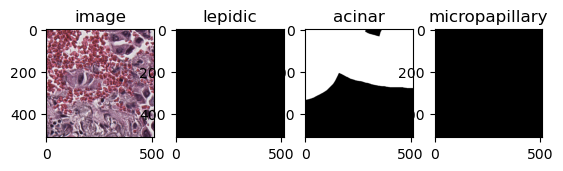

In [9]:
r = randint(0, len(images) - 1)
print(np.unique(masks[r]))

plt.subplot(1, 4, 1)
plt.title('image')
plt.imshow(images[r])

plt.subplot(1, 4, 2)
plt.title('lepidic')
plt.imshow(masks[r][0], cmap='grey')

plt.subplot(1, 4, 3)
plt.title('acinar')
plt.imshow(masks[r][1], cmap='grey')

plt.subplot(1, 4, 4)
plt.title('micropapillary')
plt.imshow(masks[r][2], cmap='grey')

plt.show()


##### Merge labels to one image

In [10]:
dimension = (masks.shape[-2], masks.shape[-1])
tmp = []
for i in range(len(masks)):
    merged = np.zeros(dimension)
    for j in range(3):
        merged = np.where(merged==0, masks[i][j], merged)
    
    tmp.append(merged)
    # masks[i] = merged 

tmp = np.asarray(tmp).reshape((N, dimension[0], dimension[1], 1))
# r = randint(0, len(masks)-1)
# print(masks[0][0][0])
masks = tmp

In [11]:
masks.shape

(80, 512, 512, 1)

##### Split dataset

In [12]:
from sklearn.model_selection import train_test_split

# split dataset into train, test, and validation
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.6, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.5, random_state=0)


[0. 2.]


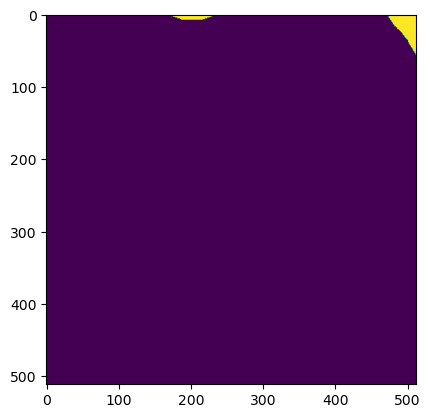

In [13]:
y_train.shape

r = randint(0, len(y_train)-1)
print(np.unique(y_train[r]))
plt.imshow(y_train[r])

In [14]:
from keras.utils import to_categorical

# categorize (format) the labels to 
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
# y_test_cat = to_categorical(y_test, num_classes=n_classes)
# train_cat

# Training

In [15]:
import keras

activation='softmax'
LR = 0.0001
opt = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [16]:
BACKBONE = 'resnet34'

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model.compile(opt, total_loss, metrics=metrics)

# model.summary()

In [17]:
preprocess_input = sm.get_preprocessing(BACKBONE)
pre_x_train = preprocess_input(x_train)
pre_x_val = preprocess_input(x_val)

# history = model.fit(pre_x_train, 
#           y_train_cat,
#           validation_data=(pre_x_val, y_val_cat),
#           batch_size=4, 
#           verbose=2,
#           epochs=20
#           )

# model.save('test.keras')

In [18]:
from keras.models import load_model

model = load_model('./test.keras', compile=False)

In [19]:
pre_x_test = preprocess_input(x_test)
y_pred = model.predict(pre_x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

2/2 [==============================] - 24s 8s/step


In [20]:
y_pred_argmax.shape

(48, 512, 512)

In [21]:
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5894133


In [22]:
def gray_to_rgb(x):
    x_reshaped = np.concatenate([x] * 3, axis=-1)
    color_map = {
            1: [255, 0, 0],   # Red for label 1
            2: [0, 255, 0],   # Green for label 2
            3: [0, 0, 255]    # Blue for label 3
        }
    
    rgb = np.zeros_like(x_reshaped, dtype=np.uint8)
    for label, color in color_map.items():
            rgb[x_reshaped[..., 0] == label] = color 
    return rgb


In [23]:
"""
    1 - Lepidic: RED
    2 - Arcinar: GREEN
    3 - Micropapillary: BLUE
"""

y_test_show_rgb = gray_to_rgb(y_test)

y_pred_argmax = np.expand_dims(y_pred_argmax, axis=-1)
y_pred_argmax_show_rgb = gray_to_rgb(y_pred_argmax)


(48, 512, 512, 1)
Index:  7


array([0, 1, 2, 3], dtype=int64)

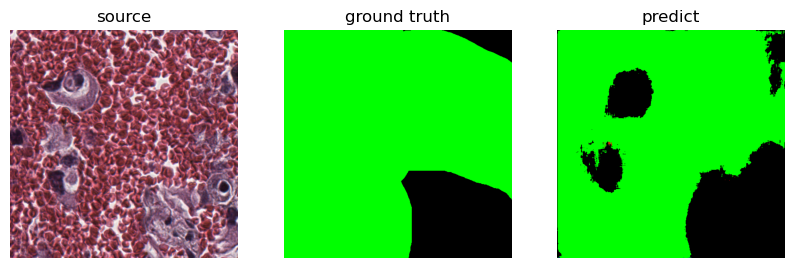

In [90]:
idx = randint(0, len(x_test)-1)
# idx = 19

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
print(y_test.shape)
print("Index: ", idx)

axs[0].imshow(x_test[idx])
axs[0].set_title("source")
axs[0].axis('off')

axs[1].imshow(y_test_show_rgb[idx], cmap='gray')
axs[1].set_title("ground truth")
axs[1].axis('off')

axs[2].imshow(y_pred_argmax_show_rgb[idx], cmap='gray')
axs[2].set_title("predict")
axs[2].axis('off')

np.unique(y_pred_argmax[idx])